In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Wed Mar 19 13:19:17 2025
@author: BJLuttgenau
"""

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
from pathlib import Path
import os
import datetime
import Automated_RGA_TEY_analysis_grouping_function as agf

# =================== SETTINGS & FOLDERS ===================

# Set directory and file paths
directory = Path("dummydata")
txt_file = directory / "sample_holder_position_readout_250321.txt"



# =================== GLOBAL BEAM INTERVAL PARAMETERS ===================

BEAM_ON_USED_S, BEAM_OFF_BEFORE_S, BEAM_OFF_AFTER_S = 20.0, 20.0, 30.0
SAVE_IMAGES = False

# =================== READ SAMPLE GROUPS ===================

df_groups = pd.read_csv(txt_file, sep="\t")
sample_groups = {grp: subdf["sample_name"].unique().tolist() for grp, subdf in df_groups.groupby("group_name")}

# =================== PLOTTING PARAMETERS ===================

plt.rcParams.update({
    "figure.figsize": (8, 6),
    "image.cmap": "viridis",
    "lines.markeredgewidth": 1,
    "font.size": 12,
    "axes.titlesize": 16,
    "axes.labelsize": 16,
    "xtick.labelsize": 12,
    "ytick.labelsize": 12,
    "legend.fontsize": 12,
    "figure.titlesize": 20
})
plt.style.use("seaborn-v0_8-whitegrid")

# =================== CREATE OUTPUT FOLDERS ===================

folders = { "raw_data": "rawdataplots", "plots": "plots", "outgassing": "outgassing_data" }
for folder in folders.values():
    Path(folder).mkdir(exist_ok=True)

In [2]:
TEY_files, rga_files = agf.scan_folder(directory)
TEY_files.sort()
rga_files.sort()

# Dictionaries to store per-sample data
sample_outgassing = {}  # sample_name -> {'avg': array, 'std': array, 'sum_avg': float, 'sum_std': float}
sample_TEY = {}         # sample_name -> (time_array, TEY_normalized) 
sample_ion = {}         # sample_name -> { m/z : (time_array, corrected_data), 'sum': (time_array, sum_corrected_data) }
    

In [3]:
# Scan folder and ensure sorting
TEY_files, rga_files = map(sorted, agf.scan_folder(directory))

# Dictionaries for storing sample data
sample_outgassing, sample_TEY, sample_ion = {}, {}, {}

# Process each sample efficiently
for rga_file, TEY_file in zip(rga_files[:2], TEY_files[:2]):
    sample_name = agf.extract_sample_name(rga_file)
    #results = agf.only_process_sample(rga_file, TEY_file, directory, save=True) 
    agf.process_sample(rga_file, TEY_file, directory, save=False, plot=False,SAVE_IMAGES=True)

In [ ]:
import numpy as np
import os
from pathlib import Path
import matplotlib.pyplot as plt

# Scan folder and ensure sorting
TEY_files, rga_files = map(sorted, agf.scan_folder(directory))

# Dictionaries for storing sample data
sample_outgassing, sample_TEY, sample_ion = {}, {}, {}

# Process each sample efficiently
for rga_file, TEY_file in zip(rga_files[:2], TEY_files[:2]):
    sample_name = agf.extract_sample_name(rga_file)
    results = agf.only_process_sample(rga_file, TEY_file, directory, save=True) 
    #sample_TEY, sample_ion, sample_outgassing
    sample_outgassing.update(results[2])
    sample_TEY.update(results[0])
    sample_ion.update(results[1])

In [3]:
from os import listdir
from os.path import isfile, join, expanduser
path = './dummydata/outgassing_data/' #path to the reduced refelctivity data
onlyfiles_outgassing = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('_outgassing_data_mean_std.txt') and f.startswith('')]
onlyfiles_TEY = [f for f in listdir(path) if isfile(join(path, f)) and f.endswith('_TEY_normalized.txt') and f.startswith('')]

print(onlyfiles_outgassing)
print(onlyfiles_TEY)

labels_outgassing = []
labels_TEY = []
exp_data_all =[]

for file in onlyfiles_outgassing:
    label = file.replace('_outgassing_data_mean_std.txt','') 
    file = join(path, file)
    df = pd.read_csv(file, sep='\t',  skiprows=1 )  

    df['name'] = label  
    labels_outgassing.append(label)
    exp_data_all.append(df)

# Combine all data
df_outgassing = pd.concat(exp_data_all, ignore_index=True)

exp_data_all =[]

for file in onlyfiles_TEY:
    label = file.replace('_TEY_normalized.txt','') 
    file = join(path, file)
    df = pd.read_csv(file, sep='\t',  skiprows=1 )  

    df['name'] = label  
    labels_TEY.append(label)
    exp_data_all.append(df)

# Combine all data
df_TEY = pd.concat(exp_data_all, ignore_index=True)
df_TEY

['BL_TEY-04_outgassing_data_mean_std.txt', 'BL_TEY-06_outgassing_data_mean_std.txt', 'BL_TEY-05_outgassing_data_mean_std.txt', 'BL_TEY-01_outgassing_data_mean_std.txt', 'BL_TEY-02_outgassing_data_mean_std.txt', 'BL_TEY-03_outgassing_data_mean_std.txt']
['BL_TEY-01_TEY_normalized.txt', 'BL_TEY-03_TEY_normalized.txt', 'BL_TEY-05_TEY_normalized.txt', 'BL_TEY-04_TEY_normalized.txt', 'BL_TEY-02_TEY_normalized.txt', 'BL_TEY-06_TEY_normalized.txt']


,Time(s),Normalized_TEY,name
0,0.000000,0.000005,BL_TEY-01
1,0.029431,0.000005,BL_TEY-01
2,0.058354,0.000005,BL_TEY-01
3,0.086280,0.000005,BL_TEY-01
4,0.112708,0.000005,BL_TEY-01
...,...,...,...
50995,239.909300,0.000005,BL_TEY-06
50996,239.938300,0.000005,BL_TEY-06
50997,239.966700,0.000005,BL_TEY-06
50998,239.993400,0.000005,BL_TEY-06


In [ ]:
import nistchempy as nist
import re

s = nist.run_search('anthracene','name')
X = s.compounds[0]
X.get_ms_spectra()
ms = X.ms_specs[0]
#print(ms.jdx_text)

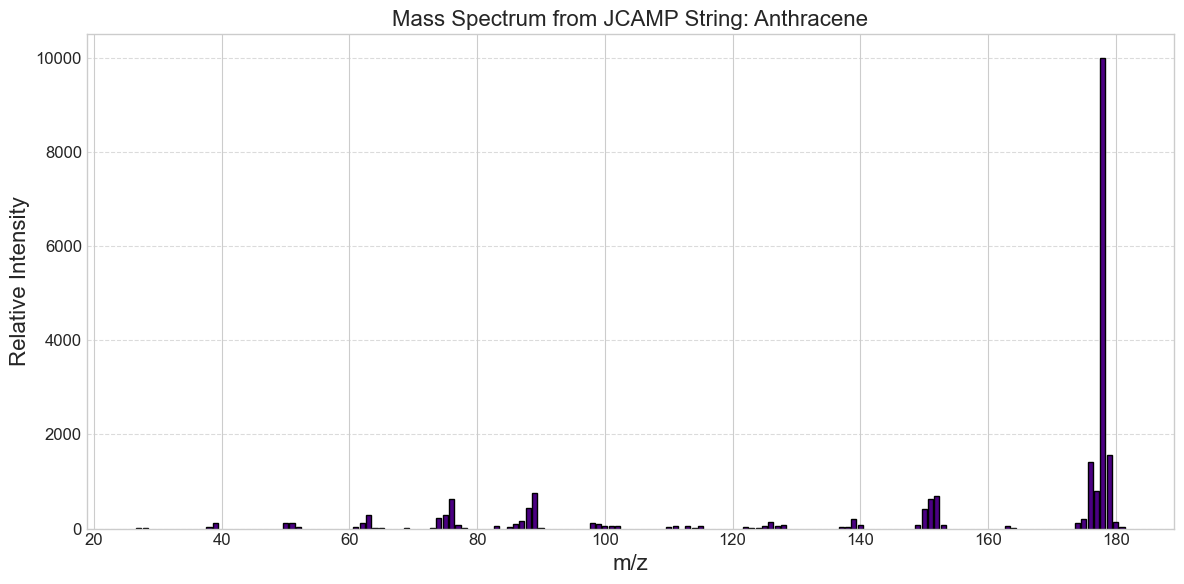

In [29]:
# Extract the PEAK TABLE block using regular expressions
s = nist.run_search('anthracene')
X = s.compounds[0]
X.get_ms_spectra()
ms = X.ms_specs[0]
jcamp_str = ms.jdx_text
peak_table_match = re.search(r"##PEAK TABLE=\(XY..XY\)(.*?)##END=", jcamp_str, re.DOTALL)
if peak_table_match:
    peak_data = peak_table_match.group(1).strip()
    pairs = re.findall(r"(\d+),(\d+)", peak_data)
    mz = [int(m) for m, _ in pairs]
    intensity = [int(i) for _, i in pairs]

    # Plotting
    plt.figure(figsize=(12, 6))
    plt.bar(mz, intensity, width=0.8, color='indigo', edgecolor='black')
    plt.xlabel("m/z")
    plt.ylabel("Relative Intensity")
    plt.title("Mass Spectrum from JCAMP String: Anthracene")
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
else:
    print("Failed to extract peak data.")


/tmp/ipykernel_619930/1084441059.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outgassing_avg[outgassing_avg < 0] = 0
/tmp/ipykernel_619930/1084441059.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outgassing_avg[outgassing_avg < 0] = 0
/tmp/ipykernel_619930/1084441059.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outgassing_std[outgassing_std > outgassing_avg] = 0
/tmp/ipykernel_619930/1084441059.py:12: SettingWith

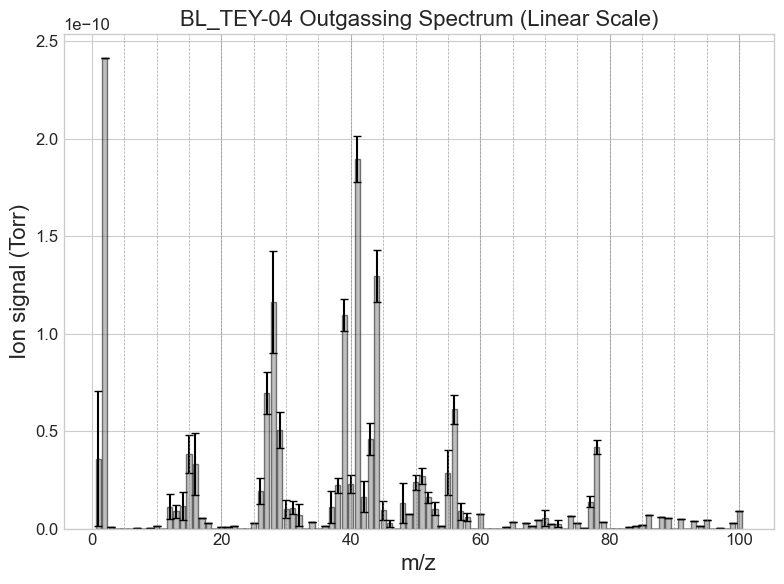

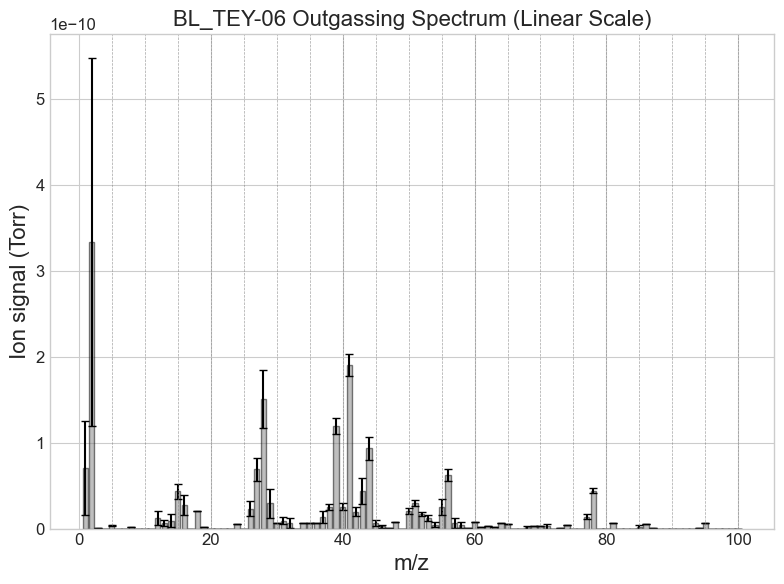

In [4]:
for name in df_outgassing['name'].unique()[:2]:
    sample_name = name
    sub_df = df_outgassing[df_outgassing['name'] == name]
    plt.figure(figsize=(8, 6))
    
    outgassing_avg = sub_df['Avg Values (Torr)']
    #print(np.shape(outgassing_avg))
    outgassing_std = sub_df['Std Values (Torr)']
    #ncols = outgassing_avg.shape[0]

    outgassing_avg[outgassing_avg < 0] = 0
    outgassing_std[outgassing_std > outgassing_avg] = 0

    plt.bar(np.arange(1,len(outgassing_avg)+1),outgassing_avg, alpha=0.5, color='gray', edgecolor='black', label=sample_name)
    plt.errorbar(np.arange(1,len(outgassing_avg)+1),outgassing_avg, yerr=outgassing_std, fmt='none', capsize=3, ecolor='black')

    for x_val in range(5, len(outgassing_avg)+1, 5):
        plt.axvline(x=x_val, color='gray', linestyle='--', alpha=0.7, linewidth=0.5)

    plt.xlabel("m/z")
    plt.ylabel("Ion signal (Torr)")
    plt.title(f"{sample_name} Outgassing Spectrum (Linear Scale)")
    plt.grid(True)
    plt.tight_layout()

In [ ]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots()

# Loop over each unique name and plot its data
for name in df_TEY['name'].unique():
    sub_df = df_TEY[df_TEY['name'] == name]
    ax.plot(sub_df['Time(s)'], sub_df['Normalized_TEY'], label=name)

ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (A)')
ax.set_title('TEY-Shutter Data')
ax.grid(True)
ax.legend()
plt.tight_layout()
plt.show()

In [ ]:
fig, ax = plt.subplots()
for key in sample_TEY.keys():
    plt.plot(sample_TEY[key][0],sample_TEY[key][1])

    
    time = sample_TEY[key][0]
    TEY_signal = sample_TEY[key][1]
    
    ax.plot(time, TEY_signal, label=f"TEY signal ({sample_name})", linewidth=3)
ax.set_xlabel('Time (s)')
ax.set_ylabel('Amplitude (A)')
plt.legend()
plt.title(f'TEY-Shutter Data')
plt.grid(True)
plt.tight_layout()

In [ ]:
for key in sample_outgassing.keys():
    plt.figure(figsize=(8, 6))
    
    outgassing_avg = sample_outgassing[key]['avg']
    #print(np.shape(outgassing_avg))
    outgassing_std = sample_outgassing[key]['std']
    #ncols = outgassing_avg.shape[0]

    outgassing_avg[outgassing_avg < 0] = 0
    outgassing_std[outgassing_std > outgassing_avg] = 0

    plt.bar(np.arange(1,len(outgassing_avg)+1),outgassing_avg, alpha=0.5, color='gray', edgecolor='black', label=sample_name)
    plt.errorbar(np.arange(1,len(outgassing_avg)+1),outgassing_avg, yerr=outgassing_std, fmt='none', capsize=3, ecolor='black')

    for x_val in range(5, len(outgassing_avg)+1, 5):
        plt.axvline(x=x_val, color='gray', linestyle='--', alpha=0.7, linewidth=0.5)

    plt.xlabel("m/z")
    plt.ylabel("Ion signal (Torr)")
    plt.title(f"{sample_name} Outgassing Spectrum (Linear Scale)")
    plt.grid(True)
    plt.tight_layout()

In [ ]:
# =================== PLOTTING & PROCESSING FUNCTIONS ===================


def plot_all_columns_and_sum(data, sample_name,SAVE_IMAGES=False,save_path=None):
    """
    Sum the pressure values from all available mass channels and plot total pressure vs. time.
    The number of m/z channels is detected automatically.
    This is a raw sum (no background subtraction).
    """
    ncols = data.shape[1]  # first column is time; remaining columns are m/z channels
    total_pressure_sum = np.zeros(data.shape[0], dtype=float)
    for col in range(1, ncols):
        total_pressure_sum += data[:, col].astype(float)
    
    first_column = data[:, 0]
    first_column_adjusted = convert_time_to_seconds(first_column)
    
    # Filtering out negative values
    total_pressure_sum[total_pressure_sum < 0] = 0
    
    plt.figure(figsize=(10, 6))
    plt.plot(first_column_adjusted, total_pressure_sum, label='Sum of Pressures')
    plt.xlabel('Time (s)')
    plt.ylabel('Total ion signal (Torr)')
    plt.title(f'Total ion signal for {sample_name} (raw sum, no bkgd correction)')
    plt.grid(True)
    
    if SAVE_IMAGES:
        temp_fig_path = os.path.join(save_path, f'{sample_name}_sum_of_pressures.png')
        plt.savefig(temp_fig_path, bbox_inches='tight', dpi=300)
        plt.show()
    else:
        plt.show()
        #plt.close()

def process_and_plot_column(data, column_to_plot, sample_name, beam_on_indices,SAVE_IMAGES=False,save_path=None):
    """
    Process a given RGA mass channel (column), perform background subtraction based on beam-off intervals,
    and plot the corrected time trace. Returns:
       - beam_on_interval, beam_off1_interval, beam_off2_interval,
       - [avg_value]  (avg over beam-on region)
       - [std_value]  (std from beam-off region)
       - time_array: time (in seconds) for the measurement
       - corrected_data: background-corrected pressure time series
    """
    fig, ax = plt.subplots(figsize=(8, 6))
    
    first_column = data[:, 0]
    column_data = data[:, column_to_plot].astype(float)
    time_array = convert_time_to_seconds(first_column)
    
    # Compute beam intervals
    beam_on_interval, beam_off1_interval, beam_off2_interval = get_beam_intervals_in_seconds(time_array, beam_on_indices)
    
    # Fit linear background using beam-off data
    x_fit = np.concatenate((
        time_array[beam_off1_interval[0]:beam_off1_interval[1]],
        time_array[beam_off2_interval[0]:beam_off2_interval[1]]
    ))
    y_fit = np.concatenate((
        column_data[beam_off1_interval[0]:beam_off1_interval[1]],
        column_data[beam_off2_interval[0]:beam_off2_interval[1]]
    ))
    regression_coefficients = np.polyfit(x_fit, y_fit, 1)
    background_line = np.polyval(regression_coefficients, time_array)
    
    corrected_data = column_data - background_line
    ax.plot(time_array, corrected_data, label=f"m/z = {column_to_plot}")
    
    # Compute average (over beam-on region) and std (from beam-off region)
    data_beam_on = corrected_data[beam_on_interval[0]: beam_on_interval[1]]
    data_beam_off = np.concatenate((
        corrected_data[beam_off1_interval[0]:beam_off1_interval[1]],
        corrected_data[beam_off2_interval[0]:beam_off2_interval[1]]
    ))
    avg_value = np.mean(data_beam_on)
    std_value = np.std(data_beam_off)
    
    # Highlight beam intervals on the plot
    ax.axvspan(time_array[beam_on_interval[0]], time_array[beam_on_interval[1]], color='orange', alpha=0.3)
    ax.axvspan(time_array[beam_off1_interval[0]], time_array[beam_off1_interval[1]], color='gray', alpha=0.3)
    ax.axvspan(time_array[beam_off2_interval[0]], time_array[beam_off2_interval[1]], color='gray', alpha=0.3)
    
    ax.set_xlabel('Time (s)')
    ax.set_ylabel('Ion signal (Torr)')
    plt.title(f'Isolated ion signal m/z = {column_to_plot} - {sample_name}')
    plt.grid(True)
    plt.tight_layout()
    
    
    if SAVE_IMAGES:
        temp_fig_path = os.path.join(save_path, f'{sample_name}_mass_{column_to_plot}_background_correction.png')
        plt.savefig(temp_fig_path, bbox_inches='tight', dpi=300)
        plt.show()
    else:
        plt.show()
        #plt.close(fig)

    
    return beam_on_interval, beam_off1_interval, beam_off2_interval, [avg_value], [std_value], time_array, corrected_data

def process_sample(rga_file, TEY_file, directory, save=True, plot=True,SAVE_IMAGES=False):
    """
    Processes a sample by extracting data, normalizing TEY signal, 
    processing RGA channels, and optionally saving & plotting results.

    Args:
        rga_file (str): Path to RGA file.
        TEY_file (str): Path to TEY file.
        directory (str): Base directory for saving data.
        save (bool): Whether to save results to disk.
        plot (bool): Whether to generate plots.

    Returns:
        dict: Processed data including TEY signals and outgassing statistics.
    """
    sample_name = extract_sample_name(rga_file)
    print(f"Processing sample: {sample_name}")

    # Load TEY & RGA data
    TEY_data = np.loadtxt(TEY_file, skiprows=1, delimiter='\t', dtype=float)
    rga_data = np.genfromtxt(rga_file, delimiter='\t', skip_header=2, dtype=str)
    ncols = rga_data.shape[1]

    # Normalize TEY data
    TEY_time, TEY_signal = TEY_data[:, 0], TEY_data[:, 1]
    pd_current = parse_photodiode_current(TEY_file)
    TEY_signal_normalized = TEY_signal / (pd_current * 1.0e-6) if pd_current else TEY_signal
    sample_TEY = {sample_name: (TEY_time, TEY_signal_normalized)}

    # Save TEY data
    if save:
        save_path = Path(directory) / "outgassing_data" / f"{sample_name}_TEY_normalized.txt"
        np.savetxt(save_path, np.column_stack((TEY_time, TEY_signal_normalized)), fmt="%.6e", delimiter="\t",
                   header=f"TEY data for {sample_name}\nTime(s)\tNormalized_TEY", comments="")

    # Plot total raw sum (no background correction)
    if plot:
        plot_all_columns_and_sum(rga_data, sample_name)

    # Process mass channels efficiently using dictionary comprehension
    sample_ion = {
        col: process_and_plot_column(rga_data, col, sample_name, determine_intervals(TEY_file, rga_file))
        for col in range(1, ncols)
    }

    # Extract outgassing averages and standard deviations
    outgassing_avg = np.array([sample_ion[col][3][0] for col in range(1, ncols)])
    outgassing_std = np.array([sample_ion[col][4][0] for col in range(1, ncols)])

    sample_outgassing = {sample_name: {'avg': outgassing_avg, 'std': outgassing_std}}

    # Save outgassing data summary
    if save:
        save_path = Path(directory) / "outgassing_data" / f"{sample_name}_outgassing_data_mean_std.txt"
        np.savetxt(save_path, np.column_stack((np.arange(1, ncols), outgassing_avg, outgassing_std)), fmt="%d\t%.6e\t%.6e",
                   delimiter="\t", header=f"Outgassing data {sample_name}\nMass number\tAvg Values (Torr)\tStd Values (Torr)", comments="")

        print(f"Data saved for {sample_name}")

    # ======= Plot Outgassing Spectra =======
    if plot:
        plt.figure(figsize=(8, 6))
        outgassing_avg[outgassing_avg < 0] = 0
        outgassing_std[outgassing_std > outgassing_avg] = 0

        plt.bar(np.arange(1, ncols), outgassing_avg, alpha=0.5, color='gray', edgecolor='black', label=sample_name)
        plt.errorbar(np.arange(1, ncols), outgassing_avg, yerr=outgassing_std, fmt='none', capsize=3, ecolor='black')

        for x_val in range(5, ncols, 5):
            plt.axvline(x=x_val, color='gray', linestyle='--', alpha=0.7, linewidth=0.5)

        plt.xlabel("m/z")
        plt.ylabel("Ion signal (Torr)")
        plt.title(f"{sample_name} Outgassing Spectrum (Linear Scale)")
        plt.grid(True)
        plt.tight_layout()

        if SAVE_IMAGES:
            save_path = Path(directory) / "plots" / f"{sample_name}_outgassing_spectrum_linear.png"
            plt.savefig(save_path, bbox_inches="tight", dpi=300)
            plt.show()
        else:
            plt.show()
            #plt.close()

    return {'TEY': sample_TEY, 'Ion': sample_ion, 'Outgassing': sample_outgassing}